# FLAIR as a predictor

à faire: 
- Transformer tout ça en geo3D x,y pour avoir des valeurs d'erreur cohérentes. Analyse des résultats sur les diff datasets

## Gowalla

In [8]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error

In [9]:
date_format = '%Y-%m-%dT%H:%M:%SZ'
df = pd.read_csv("../datasets/Gowalla/Gowalla_totalCheckins.txt", delimiter = '\t', names = ['user', 'check-in time', 'latitude', 'longitude', 'location id'])
df['timestamp'] = df['check-in time'].apply(lambda idx: datetime.timestamp(datetime.strptime(idx, date_format))/10**3)
#Je mets tout en secondes pour simplifier (du coup le epsilon peut être amené à changer)


In [10]:
df.head(10)

,user,check-in time,latitude,longitude,location id,timestamp
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,1287525.327
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,1287433.063
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,1287351.723
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,1287336.365
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,1287247.842
5,0,2010-10-12T23:58:03Z,30.261599,-97.758581,15372,1286920.683
6,0,2010-10-12T22:02:11Z,30.267910,-97.749312,21714,1286913.731
7,0,2010-10-12T19:44:40Z,30.269103,-97.749395,420315,1286905.480
8,0,2010-10-12T15:57:20Z,30.281120,-97.745211,153505,1286891.840
9,0,2010-10-12T15:19:03Z,30.269103,-97.749395,420315,1286889.543


In [11]:
#Gowalla a la brillante idée d'ordonner les timestamps du plus récent au plus ancient, ce qui m'a permis de perdre une demi-heure à trouver le pb :)
df = df.iloc[::-1]

Flairisons tout ça

In [12]:
# epsilon = 1e-2
# number_users = df['user'].iloc[-1]


# def FLAIR_insert(x0, y0, x1, y1, x, y, A0, A_min, A_max, S, A, T, t, t0):
#     x_delta, y_delta = x -x0, y -y0
#     A_t = y_delta/(x_delta+1e-8)
#     if A_min <= A_t and A_t <= A_max:
#         A0 = A_t
#         A_min = max(A_min, (y_delta-epsilon)/(x_delta + 1e-12))
#         A_max = min(A_max, (y_delta+epsilon)/(x_delta + 1e-12))
#     else: 
#         S.append((x0,y0))
#         A.append(A0)
#         T.append(t0)
#         t0 = t
#         x0, y0 = x1, y1
#         x_delta, y_delta = x -x0, y -y0
#         A0 = y_delta/(x_delta+1e-12)
#         A_min = (y_delta-epsilon)/(x_delta + 1e-12)
#         A_max = (y_delta+epsilon)/(x_delta + 1e-12)
#     x1, y1 = x, y
#     return (x0, y0, x1, y1, t0, A0, A_min, A_max)

In [13]:
# #On met les deux premiers samples 
# #comment je store tout ça 
# #on transformera en array après le traitement des données
# #Est-ce qu'on différentie par utilisateur -> pour l'instant plutôt logique que oui
# S = [] #stockera les (x,y)
# A = [] #stockera les coefs directeurs finaux
# T = [] #stockera les timestamp 

# for u in range (5):
#     S.append([])
#     A.append([])
#     T.append([])
#     if df.loc[df['user'] == u].shape[0] >= 2:
#         user_df = df.loc[df['user'] == u].reset_index(drop=True)
#         x0 = user_df['latitude'][0]
#         y0 = user_df['longitude'][0]
#         x1 = user_df['latitude'][1]
#         y1 = user_df['longitude'][1]
#         t0 = user_df['check-in time'][0]
#         t1 = user_df['check-in time'][1]
#         A0 = (y1-y0)/(x1-x0 +1e-12)
#         A_min = (y1-epsilon-y0)/(x1-x0 +1e-12)
#         A_max = (y1+epsilon-y0)/(x1-x0 +1e-12)
#         for i in range (2,user_df.shape[0]):
#             x = user_df['latitude'][i]
#             y = user_df['longitude'][i]
#             t = user_df['check-in time'][i]
#             x0, y0, x1, y1, t0, A0, A_min, A_max = FLAIR_insert(x0, y0, x1, y1, x, y, A0, A_min, A_max, S[u], A[u], T[u], t, t0)
#         S[u].append((x0,y0))
#         A[u].append(A0)
#         T[u].append(t)
# S[0]
        

In [14]:
erreur = 5*1e-2
number_users = df['user'].iloc[0]

def FLAIR_insert_1d(x0, x1, x, t0, t1, t, A0, A_min, A_max, S, A, T, epsilon):
    """Inserts a new sample (x,t) into the previous model if possible. Creates a new model otherwise.

    Args:
        x0 (_type_): first sample of the last model
        x1 (_type_): last sample of the last model
        x (_type_): sample to be inserted
        t0 (_type_): first time..
        t1 (_type_): _description_
        t (_type_): _description_
        A0 (_type_): linear coef of the current model
        A_min (_type_): _description_
        A_max (_type_): _description_
        S (_type_): stores x
        A (_type_): stores linear coefs
        T (_type_): stores time

    Returns:
        _type_: _description_
    """
    x_delta, t_delta = x -x0, t - t0
    
    A_t = x_delta/(t_delta+1e-8)
    if A_min <= A_t and A_t <= A_max:
        
        A0 = A_t
        A_min = max(A_min, (x_delta-epsilon)/(t_delta + 1e-12))
        A_max = min(A_max, (x_delta+epsilon)/(t_delta + 1e-12))
    else: 
        S.append(x0)
        A.append(A0)
        T.append(t0)
        t0 = t
        x0, t0 = x1, t1
        x_delta, t_delta = x -x0, t -t0
        A0 = x_delta/(t_delta+1e-12)
        A_min = (x_delta-epsilon)/(t_delta + 1e-12)
        A_max = (x_delta+epsilon)/(t_delta + 1e-12)
    x1, t1 = x, t 
    return (x0, t0, x1, t1, A0, A_min, A_max)

In [15]:
#FLAIR latitude
def FLAIR(mode, nb_users, df, epsilon):
    """transforms the mobility data of the different users just as in the FLAIR paper

    Args:
        mode (_type_): _description_
        nb_users (_type_): _description_
    """
    X = np.empty(nb_users, dtype=object)
    Ax = np.empty(nb_users, dtype=object) #stockera les coefs directeurs finaux
    Tx = np.empty(nb_users, dtype=object) #stockera les timestamp 
    for u in range (nb_users):
        X[u] = []
        Ax[u] = []
        Tx[u] = []
        if df.loc[df['user'] == u].shape[0] >= 2:
            user_df = df.loc[df['user'] == u].reset_index(drop=True)
            x0 = user_df[mode][0]
            x1 = user_df[mode][1]
            t0 = user_df['timestamp'][0]
            t1 = user_df['timestamp'][1]
            A0_x = (x1-x0)/(t1-t0 +1e-12)
            A_min_x = (x1-epsilon-x0)/(t1-t0 +1e-12)
            A_max_x = (x1+epsilon-x0)/(t1-t0 +1e-12)
            for i in range (2,user_df.shape[0]):
                x = user_df[mode][i]
                t = user_df['timestamp'][i]
                x0, t0, x1, t1, A0_x, A_min_x, A_max_x = FLAIR_insert_1d(x0, x1, x, t0, t1, t, A0_x, A_min_x, A_max_x, X[u], Ax[u], Tx[u], epsilon)
            X[u].append(x0)
            Ax[u].append(A0_x)
            Tx[u].append(t0)
    return(X,Ax,Tx)

In [16]:
X, Ax, Tx = FLAIR('latitude', 500, df, erreur)
Y, Ay, Ty = FLAIR('longitude', 500, df, erreur)

In [17]:
def FLAIR_predict(last_value, next_time, last_linear_coef):
    """Given a number of seconds next_time for which we want to know the user's next location. Returns the approximate latitude (or longitude)


    Args:
        last_value (_type_): _description_
        last_time (_type_): _description_
        next_time (_type_): _description_
        last_linear_coef (_type_): _description_
    """
    return(last_value+ last_linear_coef*next_time )

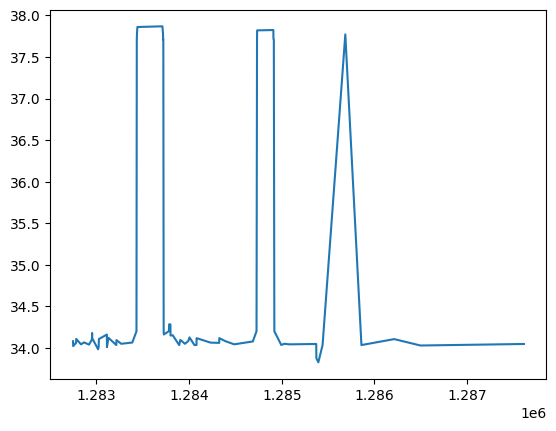

In [18]:
#ici on plot pas vraiment flair mais juste les points retenus (excepté le dernier, donc je l'ajoute à la main), càd que FLAIR donnerait à
#peu près la même chose mais avec des coefs linéaires un peu différents
Sx = np.concatenate((np.array(X[2]), np.array([df.loc[df['user'] == 2]['latitude'].iloc[-1]])))
Tx2 = np.concatenate((np.array(Tx[2]), np.array([df.loc[df['user'] == 2]['timestamp'].iloc[-1]])))
plt.plot(Tx2, Sx)

#df.loc[df['user'] == 2]['user'].shape[0]

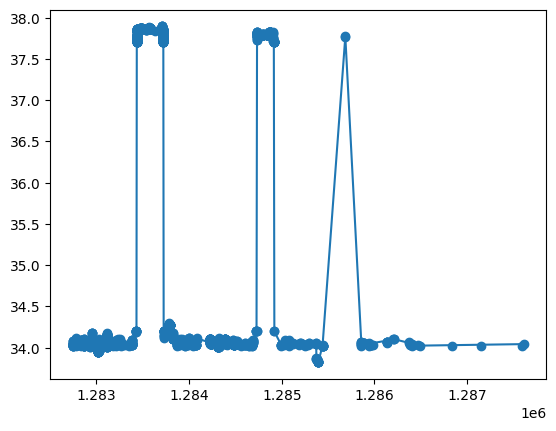

In [19]:
X2 = np.array(df.loc[df['user'] == 2]['latitude'])
T2 = np.array(df.loc[df['user'] == 2]['timestamp'])
plt.scatter(T2,X2)
plt.plot(Tx2, Sx)

In [20]:
#Pareil, on flairise
#à faire -> trouver le bon epsilon
# -> plot flair avec les bons coefs
# prediction, faire un calcul loss moyen, puis extraire les trajs où c'est pas fou

def which_model(traj_user, nbr_predictions, A, T, S):
    """Returns the last model (i.e sample and linear coefficient) before the sample of index nbr_samples - nbr_predictions

    Args:
        traj_user (df): the user df
        nbr_predictions (int): _description_
        A (array): _description_
        T (array): _description_
        S (array): _description_

    Returns:
        _type_: _description_
    """
    #traj_user correspond à df.loc[df['user'] == user].dropIndex
    time_predict = traj_user['timestamp'].iloc[- nbr_predictions]
    time_avant = traj_user['timestamp'].iloc[- nbr_predictions -1]

                 
    for i in range(1, min(len(T),nbr_predictions+1)): #ici on essaye de trouver à quel modèle correspond le sample d'indice last_index - nbr_predictions
        #on parcourt la liste T depuis la fin 
        
        #Je tiens à m'excuser auprès de toute la communauté des développeurs pour ce qui va suivre
        #modif jeudi -> je remplace -i-1 par -i
        if T[-i] < time_predict and abs(T[-i-1]-time_predict) >= 0.001 and (T[-i] - time_avant) < 0.001: #je rajoute le abs(T[-i]-time_predict) >= 0.001 parce que j'ai des problèmes de conversion
            #qui font que T[-i] et time_predict ont une valeur un tout petit peu différente alors que ça devrait être strictement égal.
            return(i+1) 
        elif T[-i] < time_predict and abs(T[-i]-time_predict) >= 0.001:
            return(i)
        # :)
    return(0)
#!!!! à regarder -> ça donne quoi si le dernier modèle commence avant time_predict mais finit après, avec le modèle qui a pu être bien défini avant time_predict (ie au moins deux points avant time_predict)
        
        
    #return(S[-i], A[-i]) #on return le bon modèle

In [21]:

#Test de la prédiction -> je pense qu'on peut difficilement faire autrement qu'au cas par cas pour les différents datasets.
#Gowalla
#Pour Gowalla, faire une prédiction du type dans les 5 prochaines minutes fait à peu près aucun sens vu la tête du dataset.
#Est-ce qu'on découpe des trajs qui font sens?

def compute_loss(traj_user, nbr_predictions, A, T, S, mode):
    prediction_model = np.array(())
#vérifier que l'utilisateur contient au moins nbr_predictions + 2 samples

#Il faut pouvoir accéder au modèle qui correspond au modèle au sample
# dernier_sample - nbr_predictions -> on regarde le temps t_oui qui correspond à dernier_sample - nbr_predictions, puis on prend le modèle
# avec t_modèle < t_oui et t_modèle_davant > t_oui
#C'est le rôle de which_model
    if traj_user.shape[0] <= nbr_predictions + 2: #Si on a pas assez de sample par rapport au nombre de prédictions qu'on veut faire -> erreur
        return(-1, -1)
        
    index = which_model(traj_user, nbr_predictions, A, T, S)
    if len(S) <= index:
        return(-1,-1)
       
    x, coef = S[-index], A[-index]
    predictions = np.zeros(nbr_predictions)
    for i in range (nbr_predictions):
        next_time = traj_user['timestamp'].iloc[-nbr_predictions +i] - traj_user['timestamp'].iloc[-nbr_predictions -1]
        predictions[i] = FLAIR_predict(x, next_time, coef)
    #On retourne l'erreur et on fera éventuellement plus tard une somme en latitude/ longitude
    return(mean_squared_error(predictions, np.array(traj_user[mode].iloc[-nbr_predictions:])), index)

def mean_loss(nb_users, nbr_predictions, Ax, Tx, X, Ay, Ty, Y, df):
    prediction_model_lat = np.zeros(nb_users) #va stocker les modèles de prédiction (leur indice)
    prediction_model_long = np.zeros(nb_users) #va stocker les modèles de prédiction
    latitude_loss = np.zeros(nb_users)
    longitude_loss = np.zeros(nb_users)
    for u in range (nb_users):
        latitude_loss[u], prediction_model_lat[u] = compute_loss(df.loc[df['user'] == u].reset_index(drop=True), nbr_predictions, Ax[u], Tx[u], X[u], 'latitude')
        longitude_loss[u], prediction_model_long[u] = compute_loss(df.loc[df['user'] == u].reset_index(drop=True), nbr_predictions, Ay[u], Ty[u], Y[u], 'longitude')
    return(latitude_loss, longitude_loss, prediction_model_lat, prediction_model_long)
        
    




In [22]:
#Pour Gowalla
latitude_loss, longitude_loss, prediction_model_lat, prediction_model_long = mean_loss (500, 3, Ax, Tx, X, Ay, Ty, Y, df)
prediction_model_lat, prediction_model_long = prediction_model_lat.astype(int), prediction_model_long.astype(int)
print("Erreur de latitude: \n")
print (latitude_loss)
print("Erreur de longitude: \n")
print (longitude_loss)

Erreur de latitude: 

[ 2.66338486e+02  6.01102642e+01  1.22762340e-02 -1.00000000e+00
  2.35480888e+02  2.86544685e+02 -1.00000000e+00  1.31931576e+01
  8.19594941e+00  1.08741989e+00  2.33449323e+00  7.53078878e+05
  3.31440146e+03  4.96984171e+00  2.40880925e+01  8.86364727e+00
  1.02125092e+04  3.36200758e-02  3.71316252e-01  1.18245462e+01
  3.69890643e-02  1.15775929e+01  2.73884142e+01  8.25528412e-02
  3.10458822e+02  2.11116111e+01  5.84669254e+01  1.44934386e-01
  2.65553760e-03  3.37711415e-03  1.04413448e+00  4.74710573e-07
  2.32269262e-03 -1.00000000e+00  5.68478216e-04  1.08017110e-02
  2.83583005e+01 -1.00000000e+00 -1.00000000e+00  1.03628665e+03
  1.78700424e+01  6.14647753e-03  1.19497004e+02  5.48311980e+02
  1.40689534e-01 -1.00000000e+00 -1.00000000e+00  2.88172243e+02
  9.56865439e-01  9.61476333e-01  3.28539178e+00  1.11130108e+02
  2.45210558e+03  7.48504823e-02  2.43469468e+02  2.54746941e-02
 -1.00000000e+00  4.42771943e+01  8.00630006e+05  4.87579871e+01
  3

On peut identifier quelques utilisateurs pour lesquels les prédictions de FLAIR n'ont pas été flamboyantes. Jetons par exemple un coup d'oeil à l'utilisateur 26

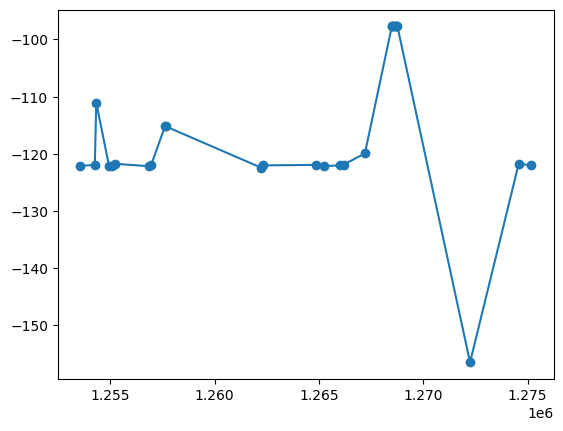

In [23]:
Sx26 = np.concatenate((np.array(Y[26]), np.array([df.loc[df['user'] == 26]['longitude'].iloc[-1]])))
Tx26 = np.concatenate((np.array(Ty[26]), np.array([df.loc[df['user'] == 26]['timestamp'].iloc[-1]])))

X26 = np.array(df.loc[df['user'] == 26]['longitude'])
T26 = np.array(df.loc[df['user'] == 26]['timestamp'])
plt.scatter(T26,X26)
plt.plot(Tx26, Sx26)

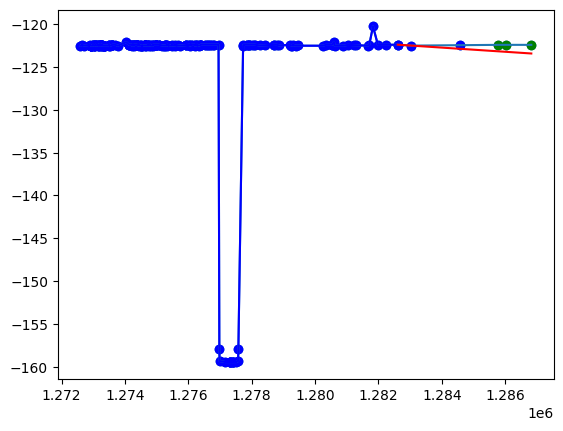

In [41]:
Sx26 = np.concatenate((np.array(Y[4]), np.array([df.loc[df['user'] == 4]['longitude'].iloc[-1]])))
Tx26 = np.concatenate((np.array(Ty[4]), np.array([df.loc[df['user'] == 4]['timestamp'].iloc[-1]])))

X26 = np.array(df.loc[df['user'] == 4]['longitude'])
T26 = np.array(df.loc[df['user'] == 4]['timestamp'])
plt.scatter(T26,X26)
plt.plot(Tx26, Sx26)
plot_prediction(X26, T26, np.array(Ay[4]), np.array(Ty[4]), np.array(Y[4]), prediction_model_long[4], 3)

Il faut bien garder en tête qu'ici ce n'est pas vraiment le modèle de FLAIR qui est affiché mais seulement les points qu'on a retenu, en ajoutant le dernier

In [24]:
#On voudrait maintenant avoir une représentation visuelle de ce qui se passe
#De quoi on a besoin:
# - Du dernier modèle (qu'on voudrait représenter genre en rouge)
# - Les points qu'on a voulu prédire (pareil une autre couleur)
# - le reste en bleu
# 
def plot_prediction(X, Timestamps, A, T, S, prediction_model_index, nb_predictions):
    """Plots the true samples in blue. The last nb_predictions samples in green. The prediction line in red

    Args:
        X (_type_): les vraies valeurs
        Timestamps (_type_): _description_
        A (_type_): _description_
        T (_type_): _description_
        S (_type_): _description_
        prediction_model_index (_type_): _description_
        nb_predictions (_type_): _description_
    """
    linear_coef, time_pred, x_pred = A[-prediction_model_index], T[-prediction_model_index], S[-prediction_model_index]
    plt.scatter(Timestamps[:-nb_predictions], X[:-nb_predictions], color = 'blue', label = 'known positions')
    plt.scatter(Timestamps[-nb_predictions:], X[-nb_predictions:], color = 'green', label = 'positions to be predicted')
    plt.plot(T[:-prediction_model_index+1],S[:-prediction_model_index+1], color = 'blue')
    t_max = Timestamps[-1]
    x_max = x_pred + linear_coef * (t_max - time_pred)
    plt.plot([time_pred, t_max], [x_pred, x_max], color='red', label = "FLAIR's prediction")
    plt.show()

    

    

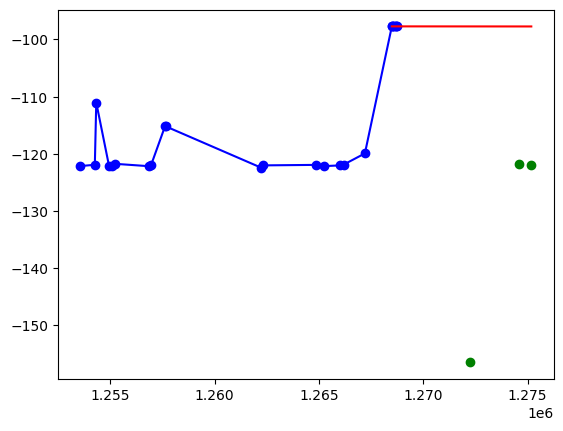

In [25]:
plot_prediction(X26, T26, np.array(Ay[26]), np.array(Ty[26]), np.array(Y[26]), prediction_model_long[26], 3)
#ici on doit avoir nb_predictions qui doit correspondre avec celui qu'on a choisit pour construire prediction_model_long


In [26]:
len(Y[26]) #+ 
len(Ay[26])

20

In [27]:
#fonction finale qui fait le plot en entrant juste l'utilisateur et le nombre de prédictions qu'on veut réaliser (du coup on recalcule 
# which_model etc)
def plot_user_Gowalla (user_index, nbr_predictions, mode, df):
    if mode == 'latitude':
        S_oui = np.array(X[user_index])
        Tx_oui = np.array(Tx[user_index])
        A_oui = np.array(Ax[user_index])
        X_oui = np.array(df.loc[df['user'] == user_index][mode])
        T_oui = np.array(df.loc[df['user'] == user_index]['timestamp'])

    else: #i.e mode == 'latitude'
        S_oui = np.array(Y[user_index])
        Tx_oui = np.array(Ty[user_index])
        A_oui = np.array(Ay[user_index])
        X_oui = np.array(df.loc[df['user'] == user_index][mode])
        T_oui = np.array(df.loc[df['user'] == user_index]['timestamp'])
    prediction_model = which_model(df.loc[df['user'] == user_index].reset_index(drop=True), nbr_predictions, A_oui, T_oui, S_oui)
    plot_prediction(X_oui, T_oui, A_oui, Tx_oui, S_oui, prediction_model_long[user_index], nbr_predictions)
    

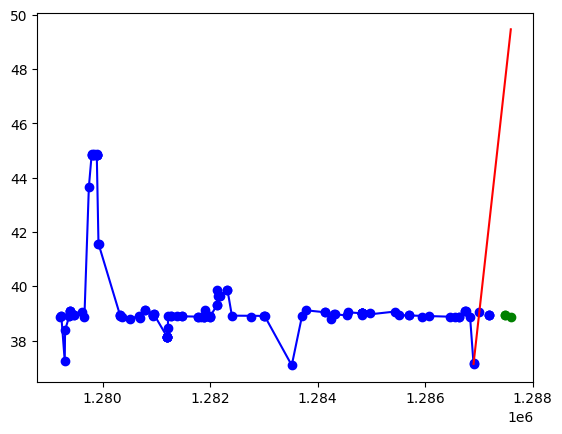

In [28]:
plot_user_Gowalla(28, 3, 'latitude', df)
#25, typiquement trajectoire horrible

In [37]:
plot_user_Gowalla(33, 3, 'latitude', df) #celui là montre bien que le epsilon choisit est pas du tout optimal.
#Typiquement là on aurait du juste avoir une ligne droite

IndexError: single positional indexer is out-of-bounds

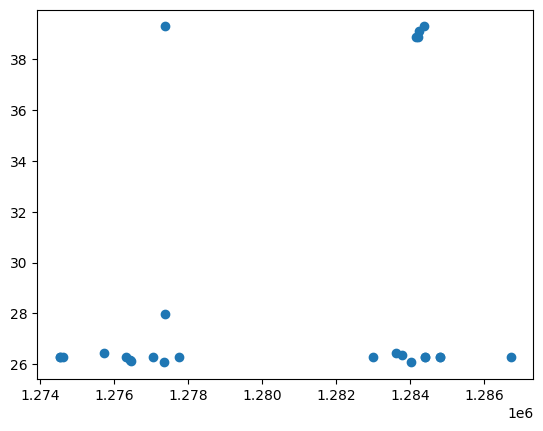

In [31]:
plt.scatter(np.array(df.loc[df['user'] == 11]['timestamp']), np.array(df.loc[df['user'] == 11]['latitude']))
#j'ai rien dit en fait, la traj est dégueulasse et c'est bien fait pour sa gueule

In [32]:
np.array(df.loc[df['user'] == 11]['latitude'])
np.array(df.loc[df['user'] == 11]['timestamp'])


array([1274542.902, 1274547.28 , 1274627.608, 1275744.324, 1276340.552,
       1276444.414, 1276461.501, 1277051.135, 1277365.135, 1277371.535,
       1277384.323, 1277746.821, 1283007.521, 1283621.307, 1283784.482,
       1284019.934, 1284163.172, 1284210.259, 1284243.616, 1284389.815,
       1284410.171, 1284413.679, 1284811.004, 1284817.662, 1286722.994])

## cabspotting

In [33]:
def read_cabspotting_data(num_users: int):
    """Puts the data in the cabspotting tree folder in a single pd dataframe

    Args:
        num_users (int): the number of users we want in our dataframe

    Returns:
        cabspotting_df: the df
    """
    data_path = '../datasets/cabspotting/cabspotting-tree/'
    user_files = os.listdir(data_path)[:num_users]
    dfs = []
    i = 0
    for file in user_files:
        filepath = os.path.join(data_path, file)
        #user = file.split('.')[0]
        df = pd.read_csv(filepath, header=None, names=['latitude', 'longitude', 'timestamp'])
        df['user'] = i
        i+=1
        df = df[['user', 'latitude', 'longitude', 'timestamp']]
        dfs.append(df)
    cabspotting_df = pd.concat(dfs, ignore_index=True)
    return geospotting_df

In [34]:
#Parameters
erreur_cab = 10**-3
nb_users_cabspotting = 10 #max = 536

In [35]:
df_cab = read_cabspotting_data(nb_users_cabspotting)
df_cab['timestamp'] = df_cab['timestamp']/10**3 #en secondes toujours
df_cab['timestamp'] = df_cab['timestamp'] - min(df_cab['timestamp']) #je 'normalise'(avec min, je veux pas de temps négatifs) pour voir (ça va influencer la valeur du epsilon)
df_cab.head(10)

NameError: name 'geospotting_df' is not defined

In [ ]:
X_cab, Ax_cab, Tx_cab = FLAIR('latitude', nb_users_cabspotting, df_cab, erreur_cab)
Y_cab, Ay_cab, Ty_cab = FLAIR('longitude', nb_users_cabspotting, df_cab, erreur_cab)

In [ ]:
latitude_loss_geo, longitude_loss_cab, prediction_model_lat_cab, prediction_model_long_cab = mean_loss (nb_users_cabspotting, 3, Ax_cab, Tx_cab, X_cab, Ay_cab, Ty_cab, Y_cab, df_cab)
prediction_model_lat_cab, prediction_model_long_cab = prediction_model_lat_cab.astype(int), prediction_model_long_cab.astype(int)
print("Erreur de latitude: \n")
print (latitude_loss_cab)
print("Erreur de longitude: \n")
print (longitude_loss_cab)

Erreur de latitude: 

[1.32515437e-06 1.97877500e-05 3.54593517e-05 1.74090702e-05
 4.07845708e-07 1.08727086e-05 9.97395629e-08 2.20155399e-06
 1.92129630e-07 1.89999083e-05]
Erreur de longitude: 

[3.49164983e-06 1.41636424e-05 3.05367527e-05 1.77547651e-05
 2.16178224e-06 1.01574557e-06 3.35037117e-08 3.12282153e-06
 1.14371543e-05 2.53054519e-07]


Sur cabspotting ça a pas l'air d'être terrible pour l'utilisateur 5, pour nb_predictions = 3. 
Plottons tout ça (risque d'être un peu illisible vu les tailles des trajectoires par utilisateur d'environ 20k samples.)

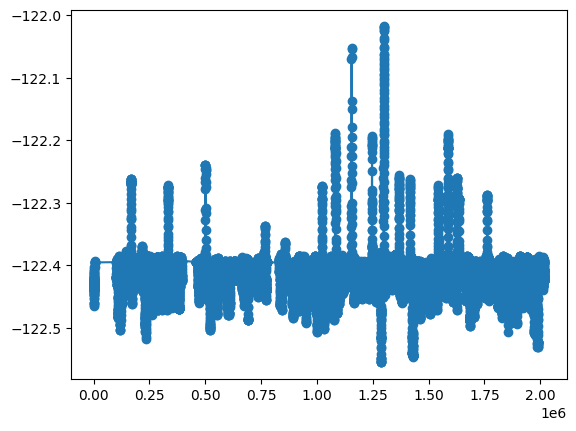

In [ ]:
Sx5 = np.concatenate((np.array(Y_cab[5]), np.array([df_cab.loc[df_cab['user'] == 5]['longitude'].iloc[-1]])))
Tx5 = np.concatenate((np.array(Ty_cab[5]), np.array([df_cab.loc[df_cab['user'] == 5]['timestamp'].iloc[-1]])))

X5 = np.array(df_cab.loc[df_cab['user'] == 5]['longitude'])
T5 = np.array(df_cab.loc[df_cab['user'] == 5]['timestamp'])
plt.scatter(T5,X5)
plt.plot(Tx5, Sx5)

In [ ]:
def plot_user_cabspotting (user_index, nbr_predictions, mode, df = df_cab):
    if mode == 'latitude':
        S_oui = np.array(X_cab[user_index])
        Tx_oui = np.array(Tx_cab[user_index])
        A_oui = np.array(Ax_cab[user_index])
        X_oui = np.array(df.loc[df['user'] == user_index][mode])
        T_oui = np.array(df.loc[df['user'] == user_index]['timestamp'])

    else: #i.e mode == 'latitude'
        S_oui = np.array(Y_cab[user_index])
        Tx_oui = np.array(Ty_cab[user_index])
        A_oui = np.array(Ay_cab[user_index])
        X_oui = np.array(df.loc[df['user'] == user_index][mode])
        T_oui = np.array(df.loc[df['user'] == user_index]['timestamp'])
    prediction_model = which_model(df.loc[df['user'] == user_index].reset_index(drop=True), nbr_predictions, A_oui, T_oui, S_oui)
    plot_prediction(X_oui, T_oui, A_oui, Tx_oui, S_oui, prediction_model_long[user_index], nbr_predictions)

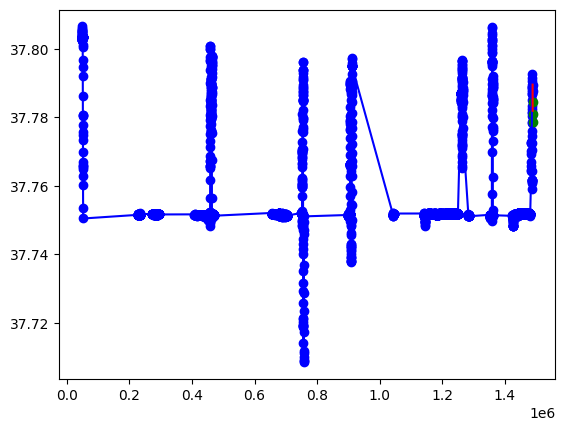

In [ ]:
plot_user_cabspotting(1, 3, 'latitude') #un peu gerbant tout de même, ya trop de points on y voit rien

Améliorations: on devrait pas avoir à refaire le calcul pour plot en changeant le nombre de prédictions -> en fait si :)

## Geo-Life

Geo-Life a l'avantage de découper son dataset en trajectoires

In [ ]:
#Parameters Geo-Life
nb_users_geo = 10
erreur_geo = 10**-3
number_predictions = 3

In [ ]:
#Je compte chaque trajectoire comme un utilisateur différent pour pas avoir à modifier FLAIR

def read_geolife_data(num_users: int):
    """Puts geolife data of a fixed number of users in a single pd dataframe (all trajectories of each user included)

    Args:
        num_users (int): the number of users we want in our dataframe

    Returns:
        cabspotting_df: the df
    """
    data_path = '../datasets/Geolife/Data/'
    user_files = os.listdir(data_path)[:num_users]
    dfs = []
    user_id = 0
    for file in user_files:
        traj_files = os.listdir(data_path + str(file) + '/Trajectory/')
        for traj in traj_files:
            filepath = os.path.join(data_path + str(file) + '/Trajectory/', traj)
            with open(filepath, 'r') as f:
                lines = f.readlines()[6:] #on s'en fiche des 6 premières lignes
            data = np.zeros((len(lines),5))
            i = 0
            min_time = (float(lines[0].split(',')[4])- 365*70)*3600*24
            for line in lines:
                line = line.split(',')
                lat = float(line[0])
                long = float(line[1])
                altitude = float(line[3])
                seconds = (float(line[4]) - 365*70)*3600*24 - min_time #je convertis en secondes depuis le 1er janvier 1970 (à peu près) pour avoir comme pour cabspotting
                data[i] = ([user_id, lat, long, altitude, seconds])
                i += 1
            df = pd.DataFrame(data, columns=['user','latitude', 'longitude', 'altitude', 'timestamp'])
            dfs.append(df)
            user_id +=1
    return (pd.concat(dfs, ignore_index=True))


In [ ]:
df_geo = read_geolife_data(nb_users_geo)
df_geo['timestamp'] = df_geo['timestamp'] - min(df_geo['timestamp'])
nb_trajectories = int(df_geo['user'].max())

In [ ]:
#FLAIR
X_geo, Ax_geo, Tx_geo = FLAIR('latitude', nb_trajectories, df_geo, erreur_geo)
Y_geo, Ay_geo, Ty_geo = FLAIR('longitude', nb_trajectories, df_geo, erreur_geo)

In [ ]:
#les erreurs
latitude_loss_geo, longitude_loss_geo, prediction_model_lat_geo, prediction_model_long_geo = mean_loss (nb_trajectories, number_predictions, Ax_geo, Tx_geo, X_geo, Ay_geo, Ty_geo, Y_geo, df_geo)
prediction_model_lat_geo, prediction_model_long_geo = prediction_model_lat_geo.astype(int), prediction_model_long_geo.astype(int)
print("Erreur de latitude: \n")
print (latitude_loss_geo)
print("Erreur de longitude: \n")
print (longitude_loss_geo)

Erreur de latitude: 

[1.91179560e-07 1.57325973e-07 2.26898048e-07 ... 1.19063270e-08
 1.65222414e-07 2.96680402e-07]
Erreur de longitude: 

[3.19921097e-08 5.95646331e-07 1.42255031e-07 ... 6.30253590e-08
 2.92341212e-07 4.29306317e-09]


In [ ]:
#On regarde les mauvais élèves en latitude
np.where(latitude_loss_geo >= 10**-3)[0]

array([604, 798, 962], dtype=int64)

In [ ]:
def plot_user_geolife (user_index, nbr_predictions, mode, df = df_geo):
    if mode == 'latitude':
        S_oui = np.array(X_geo[user_index])
        Tx_oui = np.array(Tx_geo[user_index])
        A_oui = np.array(Ax_geo[user_index])
        X_oui = np.array(df.loc[df['user'] == user_index][mode])
        T_oui = np.array(df.loc[df['user'] == user_index]['timestamp'])
        plot_prediction(X_oui, T_oui, A_oui, Tx_oui, S_oui, prediction_model_lat_geo[user_index], nbr_predictions)

    else: #i.e mode == 'longitude'
        S_oui = np.array(Y_geo[user_index])
        Tx_oui = np.array(Ty_geo[user_index])
        A_oui = np.array(Ay_geo[user_index])
        X_oui = np.array(df.loc[df['user'] == user_index][mode])
        T_oui = np.array(df.loc[df['user'] == user_index]['timestamp'])
        plot_prediction(X_oui, T_oui, A_oui, Tx_oui, S_oui, prediction_model_long_geo[user_index], nbr_predictions)
    prediction_model = which_model(df_geo.loc[df_geo['user'] == user_index].reset_index(drop=True), nbr_predictions, A_oui, T_oui, S_oui)

In [30]:
plot_user_geolife(603, number_predictions, 'latitude')

NameError: name 'plot_user_geolife' is not defined

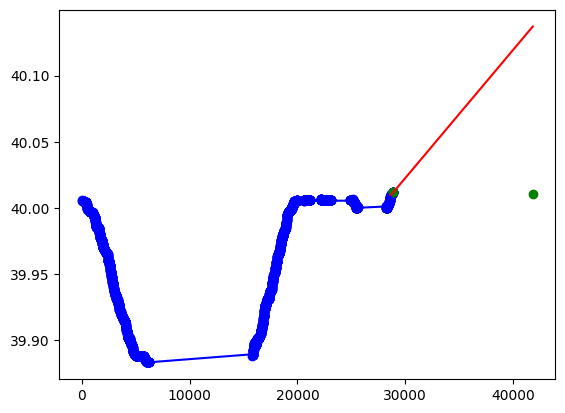

0
1


In [ ]:
plot_user_geolife(962, number_predictions, 'latitude')
#798 et 962 ont vrmt des têtes de mauvais élèves

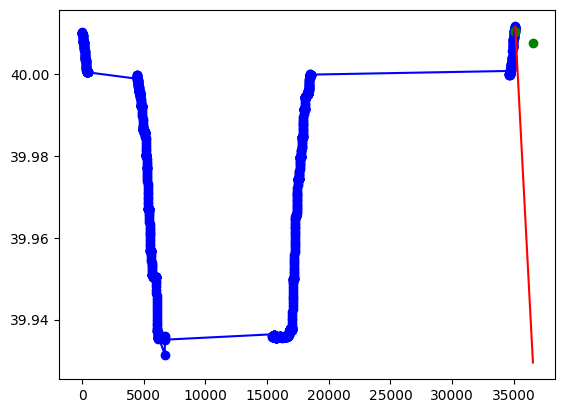

0
1


In [ ]:
plot_user_geolife(798, number_predictions, 'latitude')

In [ ]:
#Maintenant les erreurs en longitude
np.where(longitude_loss_geo >= 10**-3)[0]

array([305], dtype=int64)

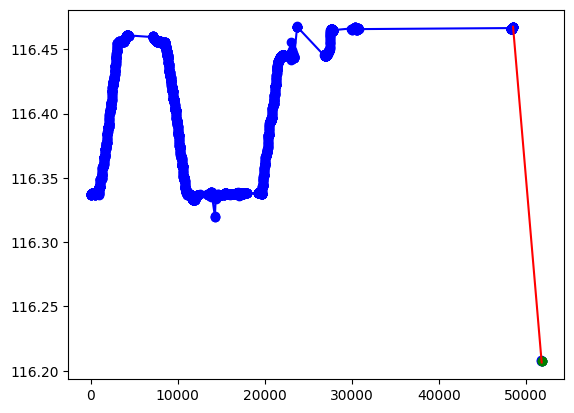

0
2


In [ ]:
plot_user_geolife(305, number_predictions, 'longitude')

In [ ]:
df_geo.loc[df_geo['user'] == 305].iloc[-15:]

,user,latitude,longitude,altitude,timestamp
403611,305.0,39.907168,116.466999,-40.0,48502.999999
403612,305.0,39.907137,116.467024,-39.0,48508.000001
403613,305.0,39.907150,116.467057,-35.0,48512.999995
403614,305.0,39.907181,116.467130,-14.0,48517.999998
403615,305.0,39.907174,116.467264,-8.0,48523.000000
403616,305.0,39.907212,116.467365,2.0,48527.999994
403617,305.0,39.907249,116.467392,5.0,48532.999997
403618,305.0,39.907246,116.467446,9.0,48537.999999
403619,305.0,39.907438,116.208164,1810.0,51794.999994
403620,305.0,39.906676,116.207675,510.0,51799.999997


Et si on change le nombre de prédictions?

In [ ]:
number_predictions = 10

latitude_loss_geo, longitude_loss_geo, prediction_model_lat_geo, prediction_model_long_geo = mean_loss (nb_trajectories, number_predictions, Ax_geo, Tx_geo, X_geo, Ay_geo, Ty_geo, Y_geo, df_geo)
prediction_model_lat_geo, prediction_model_long_geo = prediction_model_lat_geo.astype(int), prediction_model_long_geo.astype(int)
print("Erreur de latitude: \n")
print (latitude_loss_geo)
print("Erreur de longitude: \n")
print (longitude_loss_geo)

Erreur de latitude: 

[8.40855945e-08 5.83067511e-08 4.60929354e-05 ... 1.71339446e-08
 1.33781545e-07 2.96839838e-07]
Erreur de longitude: 

[1.32600749e-07 7.23559294e-08 3.03681085e-04 ... 6.65847742e-08
 2.36938185e-07 5.03797383e-09]


In [ ]:
#Les cancres
np.where(latitude_loss_geo >= 10**-3)[0]

array([ 32, 604, 962], dtype=int64)

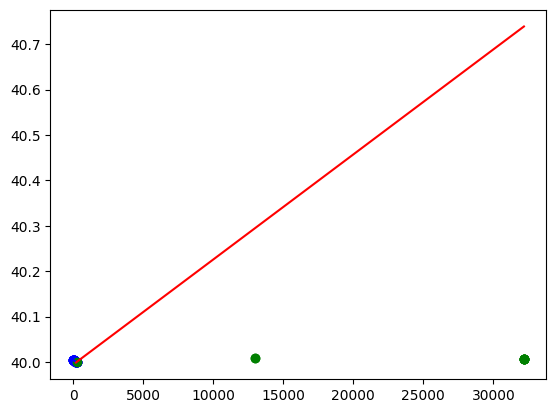

In [ ]:
plot_user_geolife(32, number_predictions, 'latitude')

In [ ]:
#df_geo.loc[df_geo['user'] == 32]
#donc là effectivement si on veut prédire les 10 prochains samples c'est complexe

In [ ]:
np.where(longitude_loss_geo >= 10**-3)[0]

array([   4,   32,  179,  202,  305, 1055], dtype=int64)

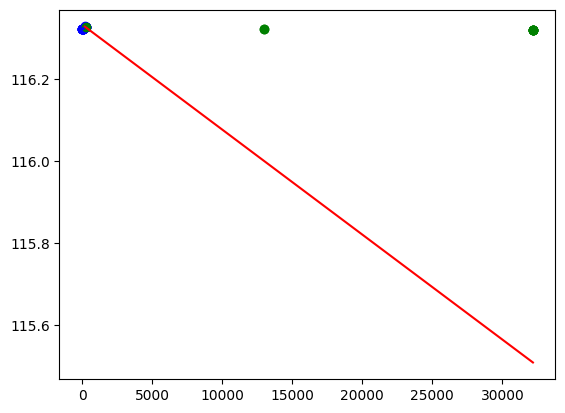

In [ ]:
plot_user_geolife(32, number_predictions, 'longitude')

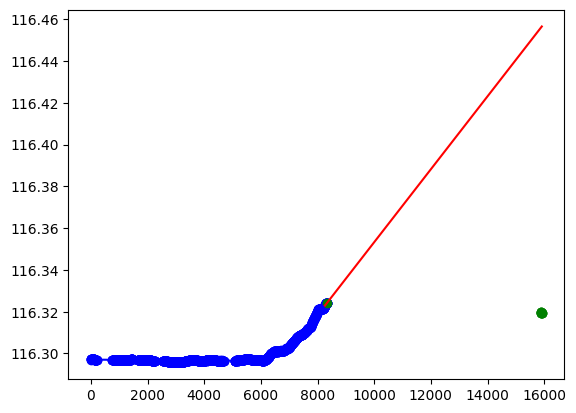

In [ ]:
plot_user_geolife(4, number_predictions, 'longitude')

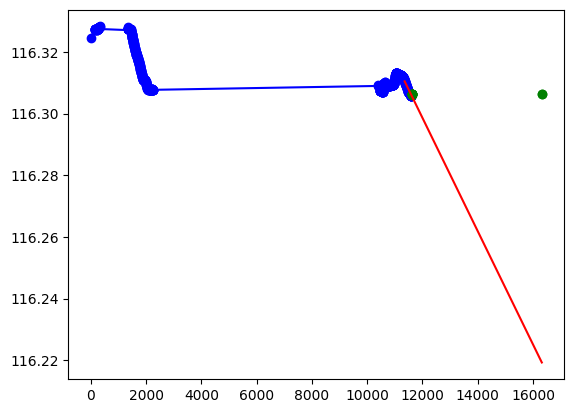

In [ ]:
plot_user_geolife(179, number_predictions, 'longitude')
#cet exemple illustre des problèmes de conversion. Normalement time_predict ici est à 8340.000002 alors que le sample associé stocké dans Ty a pas la même valeur. 
# Du coup quand je cherche le modèle associé avec T[sample] < time_predict, bah c'est vrai alors que ça devrait pas l'être.
#Je rajoute donc dans which_model un millième de seconde d'arrondis

In [ ]:

#abs(Ty_geo[4][-1]- df_geo.loc[df_geo['user'] == 4]['timestamp'].iloc[-10]) >= 0.001

116.45451240466177

In [ ]:
df_geo.loc[df_geo['user'] == 4]['timestamp'].iloc[-15:]

3409     8318.000005
3410     8320.000000
3411     8325.000003
3412     8330.000006
3413     8335.000000
3414     8340.000002
3415    15876.000000
3416    15881.000003
3417    15886.000005
3418    15890.999999
3419    15896.000002
3420    15901.000004
3421    15905.999999
3422    15911.000001
3423    15916.000003
Name: timestamp, dtype: float64

## FLAIR's performances

In [ ]:
def read_cabspotting_data(num_users: int):
    """Puts the data in the cabspotting tree folder in a single pd dataframe

    Args:
        num_users (int): the number of users we want in our dataframe

    Returns:
        cabspotting_df: the df
    """
    data_path = '../datasets/cabspotting/cabspotting-tree/'
    user_files = os.listdir(data_path)[:num_users]
    dfs = []
    i = 0
    for file in user_files:
        filepath = os.path.join(data_path, file)
        #user = file.split('.')[0]
        df = pd.read_csv(filepath, header=None, names=['latitude', 'longitude', 'timestamp'])
        df['user'] = i
        i+=1
        df = df[['user', 'latitude', 'longitude', 'timestamp']]
        dfs.append(df)
    cabspotting_df = pd.concat(dfs, ignore_index=True)
    return geospotting_df